# PREDICTING HOME VALUES

## 1. Introduction

This notebook shows the analysis used in my 'Predicting Home Value' paper. The goal of this analysis is to build an accurate model to predict home values and identify the most important features for predicting the value of a home.

In [205]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_log_error

For this analysis, we will be using the 'House Prices' dataset from Kaggle. Our first step is to read in the dataset. Let's take an initial look at our dataset. We can explore what types of features we are working with and how large the dataset is.

In [206]:
#read in the dataset
hp = pd.read_csv('../input/train.csv')

hp.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [207]:
#check how large the dataset is
print(hp.shape)

(1460, 81)


## 2. Exploratory Analysis

In general, house prices tend to increase based on size. Let's check if the data validates this by looking at correlation between size features and SalePrice. We will look at two size features in particular, lot area and living area.

In [208]:
#correlation of lot area and SalePrice
print('Lot area: {}'.format(hp['LotArea'].corr(hp['SalePrice'])))

#correlation of living area and SalePrice
print('Living area: {}'.format(hp['GrLivArea'].corr(hp['SalePrice'])))

Lot area: 0.2638433538714056
Living area: 0.7086244776126523


Lot area is not very correlated to SalePrice but living area has a pretty strong correlation to sale price. Let's investigate this further by visualizing the relationship between living area and sale price.

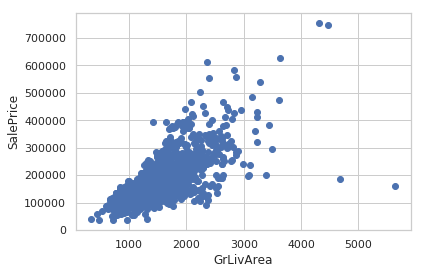

In [209]:
#scatter plot of GrLivArea vs. SalePrice
plt.scatter(x = hp['GrLivArea'], y = hp['SalePrice'])
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.show()

There is a pretty clear positive correlation in the graph. There are also two very noticeable outliers, which may have a negative effect on our model. Let's drop them.


In [210]:
#drop outliers
hp = hp.drop(hp[(hp['GrLivArea']>4000) & (hp['SalePrice']<200000)].index)

hp.shape

(1458, 81)

Since we have just dropped 2 rows from our dataframe, our index is not chronological anymore. This creates an error when inputting data into our models so to avoid this we can reset the index of our dataframe.

In [211]:
#reset index
hp = hp.reset_index(drop=True)

Let's reproduce the the graph to show the relationship of living area and sale price without the outlier data points. Without the outliers, the correlation between living area and sale price will improve.

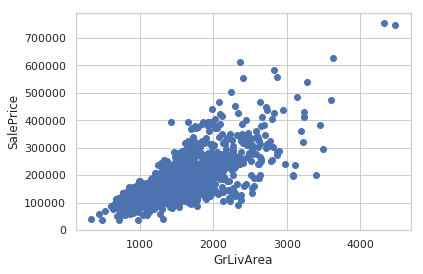

In [212]:
#reproduce the graph without the outliers
plt.scatter(x = hp['GrLivArea'], y = hp['SalePrice'])
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.show()

The graph looks much better. Let's see how this improved the correlation between living area and sale price.

In [213]:
print(hp['GrLivArea'].corr(hp['SalePrice']))

0.7349681645359327


By removing just 2 outlier data points out of a dataset of 1460 data points, the correlation has increased, which can help us obtain more accurate SalePrice predictions.

Let's take a look at which other features are strongly correlated with SalePrice. This can give us an inital idea of features that are important in predicting home value.

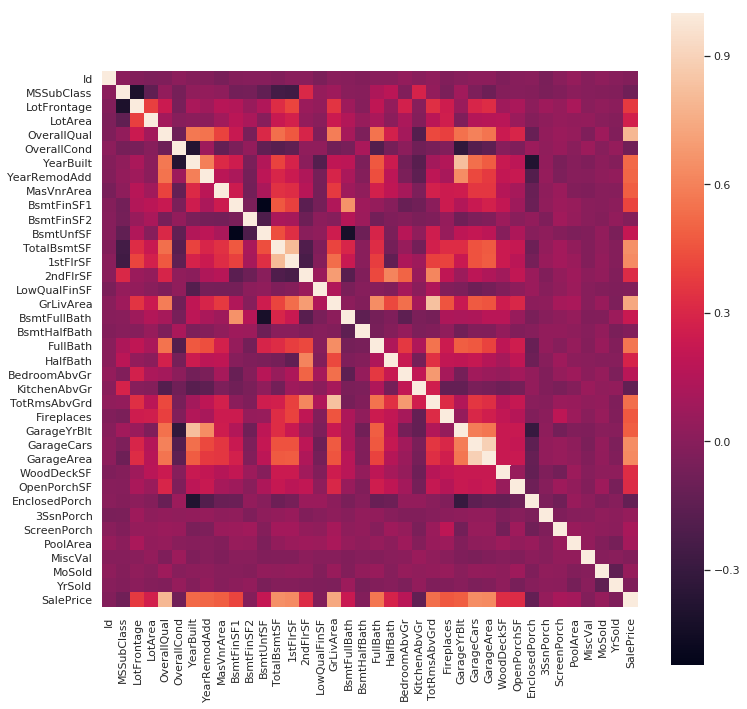

In [214]:
heatmap = hp.corr()
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(heatmap, square=True)

Our heatmap shows us that overall quality, basement size, first floor size, number of full bathrooms, number of rooms, and garage size also have a strong positive correlation to sale price.

Now let's split our data into input and target variables. For our input, we will drop ID since it's not relevant when modeling, and SalePrice, since it's the target variable.

In [215]:
#drop id column - no need for it in our model
#drop target column
X = hp.drop(columns=['Id', 'SalePrice'])

X.shape

(1458, 79)

In [216]:
#'SalePrice' is the target column
y = hp['SalePrice']

y.head()

0    208500
1    181500
2    223500
3    140000
4    250000
Name: SalePrice, dtype: int64

## 3. Missing Values

Let's take an inital look at the data to see where there are missing values. 

In [217]:
#check for missing data in our dataset - in percentage
missing_data = (X.isnull().sum())
missing_data = missing_data.drop(missing_data[missing_data == 0].index).sort_values(ascending=False)

missing_data

PoolQC          1452
MiscFeature     1404
Alley           1367
Fence           1177
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

There are a lot of missing values in the dataset. Because there a lot of missing values and the data is a mixture of numerical and categorical data, there isn't a one step solves all solution. We will have to dive deeper to take a look at the individual columns with missing values.

Some columns have missing values because the house does not have those features present. For example, not all houses have pools. For the categorical features where this occurs, we will replace the misssing value with 'None'.

In [218]:
#columns where missing values indicate feature not present - categorical
col_no_feature = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'GarageType', 'GarageFinish', 'GarageCond', 'GarageQual', 'MasVnrType']

In [219]:
#fill in columns with no features with 'None'
X[col_no_feature] = X[col_no_feature].fillna('None')

X.tail(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1453,60,RL,62.0,7917,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,None,None,None,0,8,2007,WD,Normal
1454,20,RL,85.0,13175,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,None,MnPrv,None,0,2,2010,WD,Normal
1455,70,RL,66.0,9042,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,None,GdPrv,Shed,2500,5,2010,WD,Normal
1456,20,RL,68.0,9717,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,Y,FuseA,1078,0,0,1078,1,0,1,0,2,1,Gd,5,Typ,0,None,Attchd,1950.0,Unf,1,240,TA,TA,Y,366,0,112,0,0,0,None,None,None,0,4,2010,WD,Normal
1457,20,RL,75.0,9937,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,6,1965,1965,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,CBlock,TA,TA,No,BLQ,830,LwQ,290,136,1256,GasA,Gd,Y,SBrkr,1256,0,0,1256,1,0,1,1,3,1,TA,6,Typ,0,None,Attchd,1965.0,Fin,1,276,TA,TA,Y,736,68,0,0,0,0,None,None,None,0,6,2008,WD,Normal


Let's take a look at LotFrontage, which is the length of the street connected to the property in feet.  We can replace the missing values with either the mean or median of LotFrontage in our dataset. If the mean varies significantly from the median, then we will choose the median instead of the mean, because that indicates that were are some extreme values skewing the mean.

In [220]:
print(X['LotFrontage'].isnull().sum())
print(X['LotFrontage'].values[:30])
print('mean: {}'.format(X['LotFrontage'].mean()))
print('median: {}'.format(X['LotFrontage'].median()))

259
[ 65.  80.  68.  60.  84.  85.  75.  nan  51.  50.  70.  85.  nan  91.
  nan  51.  nan  72.  66.  70. 101.  57.  75.  44.  nan 110.  60.  98.
  47.  60.]
mean: 69.79733110925771
median: 69.0


The mean and median are very close, so we can just go ahead and replace the missing values with the mean.

In [221]:
#replace missing values with mean
X['LotFrontage'] = X['LotFrontage'].fillna(X['LotFrontage'].mean())

(X['LotFrontage'].values[:10])                              

array([65.        , 80.        , 68.        , 60.        , 84.        ,
       85.        , 75.        , 69.79733111, 51.        , 50.        ])

Next, let's look at the missing values of MasVnrArea, which is the size of the Veneer Area in a house. The missing values indicate that this feature is not present in the house, so we can go ahead and fill in the missing value with 0, since it is a numerical feature.

In [222]:
#look at MasVnrArea column stats
print(X['MasVnrArea'].describe())

count    1450.000000
mean      102.753793
std       179.442156
min         0.000000
25%         0.000000
50%         0.000000
75%       164.750000
max      1600.000000
Name: MasVnrArea, dtype: float64


In [223]:
#replace missing values with 0
X['MasVnrArea'] = X['MasVnrArea'].fillna(0)

#check that there are no more missing values for MasVnrArea
print('Missing Values (MasVnrArea): {}'.format(X['MasVnrArea'].isnull().sum()))

Missing Values (MasVnrArea): 0


GarageYrBlt has the same situation as MasVnrArea above, where these houses don't have garages. So we will replace those missing values with 0.

In [224]:
#replace missing values with 0
X['GarageYrBlt'] = X['GarageYrBlt'].fillna(0)

#check that there are no more missing values for GarageYrBlt
print('Missing Values (GarageYrBlt): {}'.format(X['GarageYrBlt'].isnull().sum()))

Missing Values (GarageYrBlt): 0


Electrical is the type of electrical system the house uses. Let's inspect this column to see how to best replace the missing values.

In [225]:
#Electrical column values
print(X['Electrical'].value_counts())

SBrkr    1332
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64


There is only one missing value and a majority of the values for this feature are 'SBrkr', which stands for standard circuit breaker. From the data, it would be save to assume that the house with the missing value would also use a standard circuit breaker as its electrical system, so let's go ahead and replace the missing value with 'SBrkr'.

In [226]:
#replace missing value for Electrical with SBrkr
X['Electrical'] = X['Electrical'].fillna('SBrkr')
print('Missing Values (Electrical): {}'.format(X['Electrical'].isnull().sum()))

Missing Values (Electrical): 0


That should take care of all our columns with missing values. Let's double check to be sure.

In [227]:
missing_data2 = (X.isnull().sum() / len(X)) * 100
missing_data2 = missing_data2.drop(missing_data2[missing_data2 == 0].index).sort_values(ascending=False)

missing_data2

Series([], dtype: float64)

Great, we've taken care of all the missing values!

In the inital inspection of the data, I noticed that the Utilities column had all the same values. This makes sense because houses should all have access to basic utilties (water, gas, electric). Let's inspect this.

In [228]:
print(X['Utilities'].value_counts())

AllPub    1457
NoSeWa       1
Name: Utilities, dtype: int64


Since all the values are the same except one, this won't be much use when we input the data into our models. We can go ahead and drop this column.

In [229]:
#drop utilties column
X = X.drop(columns=['Utilities'])

X.shape

(1458, 78)

## 4. Categorical Features

Now let's deal with the categorical features in our dataset. We can split these up into 2 types of categorical features: ordered and unordered. 

For the ordered variables, we can keep the feature in one column, and order them based on preference. For example, in a feature measuring quality, poor quality should be below excellent. Then we can convert the strings in the columns into numerical codes so that they can be inputted into the models.

For the unordered categorical features, we can use the pandas 'get_dummies' function to create a new column for each choice in a feature.

In [230]:
#Order categorical features
X["BsmtCond"] = X["BsmtCond"].astype("category",categories=['No','Po','Fa','TA','Gd','Ex'],ordered=True).cat.codes
X["BsmtExposure"] = X["BsmtExposure"].astype("category",categories=['No','Mn','Av','Gd'],ordered=True).cat.codes
X["BsmtFinType1"] = X["BsmtFinType1"].astype("category",categories=['No','Unf','LwQ','Rec','BLQ','ALQ','GLQ'],ordered=True).cat.codes
X["BsmtFinType2"] = X["BsmtFinType2"].astype("category",categories=['No','Unf','LwQ','Rec','BLQ','ALQ','GLQ'],ordered=True).cat.codes
X["BsmtQual"] = X["BsmtQual"].astype("category",categories=['No','Po','Fa','TA','Gd','Ex'],ordered=True).cat.codes
X["ExterCond"] = X["ExterCond"].astype("category",categories=['Po','Fa','TA','Gd','Ex'],ordered=True).cat.codes
X["ExterQual"] = X["ExterQual"].astype("category",categories=['Po','Fa','TA','Gd','Ex'],ordered=True).cat.codes
X["Fence"] = X["Fence"].astype("category",categories=['No','MnWw','GdWo','MnPrv','GdPrv'],ordered=True).cat.codes
X["FireplaceQu"] = X["FireplaceQu"].astype("category",categories=['No','Po','Fa','TA','Gd','Ex'],ordered=True).cat.codes
X["Functional"] = X["Functional"].astype("category",categories=['Sal','Sev','Maj2','Maj1','Mod','Min2','Min1','Typ'],ordered=True).cat.codes
X["GarageCond"] = X["GarageCond"].astype("category",categories=['No','Po','Fa','TA','Gd','Ex'],ordered=True).cat.codes
X["GarageFinish"] = X["GarageFinish"].astype("category",categories=['No','Unf','RFn','Fin'],ordered=True).cat.codes
X["GarageQual"] = X["GarageQual"].astype("category",categories=['No','Po','Fa','TA','Gd','Ex'],ordered=True).cat.codes
X["HeatingQC"] = X["HeatingQC"].astype("category",categories=['Po','Fa','TA','Gd','Ex'],ordered=True).cat.codes
X["KitchenQual"] = X["KitchenQual"].astype("category",categories=['Po','Fa','TA','Gd','Ex'],ordered=True).cat.codes
X["PavedDrive"] = X["PavedDrive"].astype("category",categories=['N','P','Y'],ordered=True).cat.codes
X["PoolQC"] = X["PoolQC"].astype("category",categories=['No','Fa','TA','Gd','Ex'],ordered=True).cat.codes

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDty

In [231]:
#Dummies for unordered categorical features
X = pd.get_dummies(X, columns=["Alley","BldgType","CentralAir",
"Condition1","Condition2","Electrical","Exterior1st","Exterior2nd","Foundation",
"GarageType","Heating","HouseStyle","LandContour","LandSlope","LotConfig","LotShape",
"MSZoning","MasVnrType","MiscFeature","Neighborhood","RoofMatl","RoofStyle",
"SaleCondition","SaleType","Street","MSSubClass",'MoSold','YrSold'],drop_first=True)

In [232]:
X.shape

(1458, 229)

The get_dummies function created a lot of new columns in our dataset. This can be useful for our model for interpreting categorical features, but the more features added, the longer the models will take to train. We will take another look at feature importance shortly too see if we can reduce the number of features in our dataset without hurting our models.

## 5. Numerical Features

We've dealt with the categorical features, now let's move on to the numerical features. The variances between the features vary greatly, and this can harm the performance of our models, so let's scale the numerical features so they are all between -1 and 1.

In [233]:
#numerical features
num_cols = ["BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","GarageArea","MasVnrArea" ,"TotalBsmtSF","1stFlrSF","2ndFlrSF","GrLivArea","LotArea","LowQualFinSF","OpenPorchSF","PoolArea","WoodDeckSF"]

In [234]:
#scale numerical features
scaler = StandardScaler()
X[num_cols] = pd.DataFrame(scaler.fit_transform(X[num_cols]))

X.head()

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,...,SaleCondition_Normal,SaleCondition_Partial,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,Street_Pave,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010
0,65.0,-0.203934,7,5,2003,2003,0.523937,3,2,4,3,0,6,0.617283,1,-0.288867,-0.943795,-0.473766,4,-0.814309,1.167626,-0.120325,0.393013,1,0,2,1,3,1,3,8,7,0,-1,2003.0,2,2,0.357973,3,3,...,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,80.0,-0.087252,6,8,1976,1976,-0.570739,2,2,4,3,3,5,1.245719,1,-0.288867,-0.640584,0.504925,4,0.277348,-0.794354,-0.120325,-0.489391,0,1,2,0,3,1,2,6,7,1,3,1976.0,2,2,-0.056795,3,3,...,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
2,68.0,0.080162,7,5,2001,2002,0.334044,3,2,4,3,1,6,0.108989,1,-0.288867,-0.301168,-0.319490,4,-0.642225,1.195195,-0.120325,0.542706,1,0,2,1,3,1,3,6,7,1,3,2001.0,2,2,0.640770,3,3,...,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
3,60.0,-0.092325,7,5,1915,1970,-0.570739,2,2,3,4,0,5,-0.514826,1,-0.288867,-0.061314,-0.714823,3,-0.531984,0.942481,-0.120325,0.406800,1,0,1,0,3,1,3,7,7,1,4,1998.0,1,3,0.801022,3,3,...,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,84.0,0.385566,8,5,2000,2000,1.384039,3,2,4,3,2,6,0.499451,1,-0.288867,-0.174452,0.222888,4,-0.037243,1.624809,-0.120325,1.354202,1,0,2,1,4,1,3,9,7,1,3,2000.0,2,3,1.715398,3,3,...,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0


## 6. Feature Importance

As mentioned earlier, we are going to look at feature importance for all of our features in our datasets to see what the most important features are to predict home value. To do this, we will use a tree-based feature importance method. We can run a gradient boosting model, which is a tree-based ensemble model and check which features the model found to be unimportant for predicting SalePrice. Then we can drop those features. 

Tree-based feature importance is calculated using the mean decrease impurity method. It is the total decrease in node impurity averaged over all trees of the ensemble [7] (reference page is part of the pdf file).

In [235]:
gb = GradientBoostingRegressor()
gb_param_grid = {'n_estimators': [100, 200, 300], 'max_depth': [2, 3], 'learning_rate': [0.1, 0.01]}

gb_grid = GridSearchCV(
    estimator = gb, 
    param_grid = gb_param_grid, 
    cv = 10,
    scoring = 'neg_mean_squared_log_error')

gb_grid.fit(X, y)

print(gb_grid.best_score_)
print(gb_grid.best_params_)

-0.014653239674346858
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}


In [236]:
#best gb model from grid search
gb_best = gb_grid.best_estimator_

#feature importance values
gb_best.feature_importances_[:15]

array([2.46689395e-03, 1.41773522e-02, 4.94728364e-01, 6.83441293e-03,
       2.20992909e-03, 9.01055456e-03, 6.86870573e-04, 3.62724777e-02,
       7.91836719e-05, 1.94486345e-02, 4.46030705e-05, 4.70138711e-03,
       2.27944442e-03, 3.66208266e-02, 0.00000000e+00])

In [238]:
#create dataframe of feature importances
feat_imp = {'feature': X.columns, 'importance value': gb_best.feature_importances_}
feat_imp_df = pd.DataFrame(data=feat_imp)
feat_imp_df = feat_imp_df.sort_values(by='importance value', ascending=False)

feat_imp_df.head(15)

,feature,importance value
2,OverallQual,0.494728
22,GrLivArea,0.124518
17,TotalBsmtSF,0.065628
36,GarageCars,0.037433
13,BsmtFinSF1,0.036621
7,ExterQual,0.036272
19,1stFlrSF,0.029851
29,KitchenQual,0.021404
9,BsmtQual,0.019449
1,LotArea,0.014177


The top 15 features make up a majority of the importance for predicting sale price. The bar chart below displays a visual of the top 15 importance values.

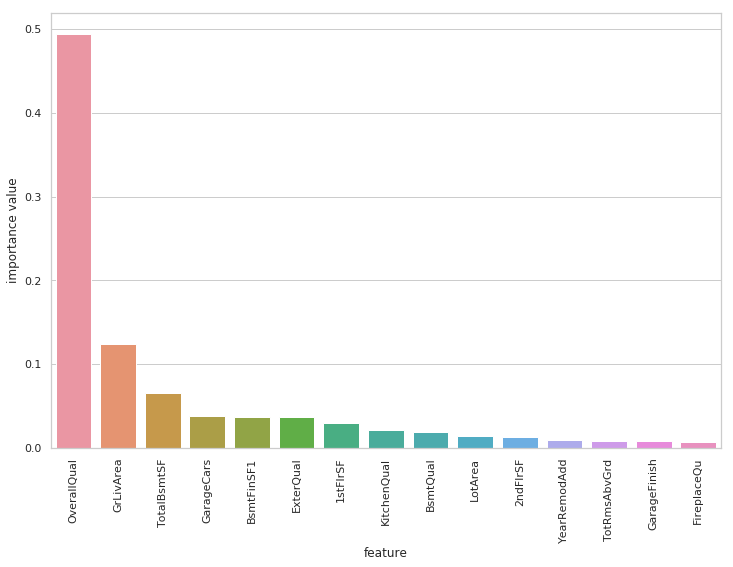

In [239]:
#bar graph showing top 15 feature importances for home value
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=feat_imp_df['feature'][:15], y=feat_imp_df['importance value'][:15], data=feat_imp_df)
plt.xticks(rotation='vertical')
plt.show()

In [240]:
#select features to drop
worst_feat_df = feat_imp_df[feat_imp_df['importance value']<0.0070]

print(len(worst_feat_df))
print(worst_feat_df.head())

214
           feature  importance value
204  MSSubClass_60          0.006859
3      OverallCond          0.006834
11    BsmtExposure          0.004701
37      GarageArea          0.004510
34     GarageYrBlt          0.003680


In [241]:
#sum of the feature importance value for features that are not top 15
worst_feat_df['importance value'].sum()

0.07362808490308455

In [242]:
#create a new datafraom using only the top 15 features
X_new_feat = X.drop(columns = worst_feat_df['feature'])

X_new_feat.shape

(1458, 15)

In [243]:
#top 15 features
X_new_feat.columns

Index(['LotArea', 'OverallQual', 'YearRemodAdd', 'ExterQual', 'BsmtQual',
       'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'KitchenQual', 'TotRmsAbvGrd', 'FireplaceQu', 'GarageFinish',
       'GarageCars'],
      dtype='object')

## 7. Model Selection

Now that we have created our new dataframe, we can split our model into training and testing data.

We will use the training data in a grid search with 10-fold cross validation for each model to choose optimal hyperparamters. We will then score each model's performance against the test set, using root mean squared log error as our scoring method.

In [244]:
X_train, X_test, y_train, y_test = train_test_split(X_new_feat, y, test_size=0.2)

In [245]:
rf = RandomForestRegressor()
rf_param_grid = {'n_estimators': [100, 200, 300], 'max_depth': [2, 3]}

rf_grid = GridSearchCV(
    estimator = rf, 
    param_grid = rf_param_grid, 
    cv = 10,
    scoring = 'neg_mean_squared_log_error',
    n_jobs = -1)

rf_grid.fit(X_train, y_train)

rf_best = rf_grid.best_estimator_
print(np.sqrt(abs(rf_grid.best_score_)))
print(rf_grid.best_params_)

0.20466548567412113
{'max_depth': 3, 'n_estimators': 300}


In [246]:
ab = AdaBoostRegressor()
ab_param_grid = {'n_estimators': [100, 200, 300], 'learning_rate': [0.1, 0.01]}

ab_grid = GridSearchCV(
    estimator = ab, 
    param_grid = ab_param_grid, 
    cv = 10,
    scoring = 'neg_mean_squared_log_error',
    n_jobs = -1)

ab_grid.fit(X_train, y_train)

ab_best = ab_grid.best_estimator_
print(ab_grid.best_score_)
print(ab_grid.best_params_)

-0.03481684995740883
{'learning_rate': 0.1, 'n_estimators': 300}


In [247]:
knnr = KNeighborsRegressor()
knnr_param_grid = {'n_neighbors': np.arange(2,15)}

knnr_grid = GridSearchCV(
    estimator = knnr, 
    param_grid = knnr_param_grid, 
    cv = 10,
    scoring = 'neg_mean_squared_log_error',
    n_jobs = -1)

knnr_grid.fit(X_train, y_train)

knnr_best = knnr_grid.best_estimator_
print(knnr_grid.best_score_)
print(knnr_grid.best_params_)

-0.029997388060059287
{'n_neighbors': 7}


In [248]:
gb2 = GradientBoostingRegressor()
gb2_param_grid = {'n_estimators': [100, 200, 300], 'max_depth': [2, 3], 'learning_rate': [0.1, 0.01]}

gb2_grid = GridSearchCV(
    estimator = gb, 
    param_grid = gb_param_grid, 
    cv = 10,
    scoring = 'neg_mean_squared_log_error',)

gb2_grid.fit(X_train, y_train)

gb2_best = gb2_grid.best_estimator_
print(gb2_grid.best_score_)
print(gb2_grid.best_params_)

-0.01894227991374551
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


In [249]:
ridge = Ridge()
ridge_param_grid = {'alpha': np.linspace(0.1,1,10)}

ridge_grid = GridSearchCV(
    estimator = ridge, 
    param_grid = ridge_param_grid, 
    cv = 10,
    n_jobs = -1)

ridge_grid.fit(X_train, y_train)

ridge_best = ridge_grid.best_estimator_
print(ridge_grid.best_score_)
print(ridge_grid.best_params_)

0.8520772562325276
{'alpha': 1.0}


In [250]:
lasso = Lasso()
lasso_param_grid = {'alpha': np.linspace(0.1,1,10)}

lasso_grid = GridSearchCV(
    estimator = lasso, 
    param_grid = lasso_param_grid, 
    cv = 5,
    n_jobs = -1)

lasso_grid.fit(X_train, y_train)

lasso_best = ridge_grid.best_estimator_
print(lasso_grid.best_score_)
print(lasso_grid.best_params_)

0.8534491380124292
{'alpha': 1.0}


In [251]:
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [252]:
#using root mean squared log error as scoring method for test set
def rmsle(real, predicted):
    sum=0.0
    for x in range(len(predicted)):
        if predicted[x]<0 or real[x]<0: #check for negative values
            continue
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        sum = sum + (p - r)**2
    return (sum/len(predicted))**0.5

All models have been optimized and trained. Now it's time to score the models against the test data using rmsle as our scoring function.

In [253]:
#model predictions
rf_pred = rf_best.predict(X_test)
gb2_pred = gb2_best.predict(X_test)
ab_pred = ab_best.predict(X_test)
knnr_pred = knnr_best.predict(X_test)
ridge_pred = ridge_best.predict(X_test)
lasso_pred = lasso_best.predict(X_test)
logreg_pred = logreg.predict(X_test)

#getting array of actual values to score model predicitons
y_test = y_test.values

#model scores using rmsle function
print('Random forest: {}'.format(rmsle(y_test, rf_pred)))
print('Gradient boosting: {}'.format(rmsle(y_test, gb2_pred)))
print('Adaboost: {}'.format(rmsle(y_test, ab_pred)))
print('k-nearest neighbors regression: {}'.format(rmsle(y_test, knnr_pred)))
print('Ridge regression: {}'.format(rmsle(y_test, ridge_pred)))
print('Lasso regression: {}'.format(rmsle(y_test, lasso_pred)))
print('Logistic regression: {}'.format(rmsle(y_test, logreg_pred)))

Random forest: 0.20393411585464502
Gradient boosting: 0.14552059670601247
Adaboost: 0.18476101437421616
k-nearest neighbors regression: 0.16732286031528287
Ridge regression: 0.19053547277516872
Lasso regression: 0.19053547277516872
Logistic regression: 0.28468671786446775


Our gradient boosting model is the most accurate model and only performs slightly worse with 15 input features than when we tested the model on all 229 features. A visual of each model's performance can be seen in the bar chart below.

In [254]:
#array of models and rmsle scores
x_model = ['Random forest', 'Gradient boosting', 'Adaboost', 'k-NN regresstion', 'Ridge regression', 'Lasso regression', 'Logistic regression']
y_rmsle = [rmsle(y_test, rf_pred), rmsle(y_test, gb2_pred), rmsle(y_test, ab_pred), rmsle(y_test, knnr_pred), rmsle(y_test, ridge_pred), rmsle(y_test, lasso_pred), rmsle(y_test, logreg_pred)]

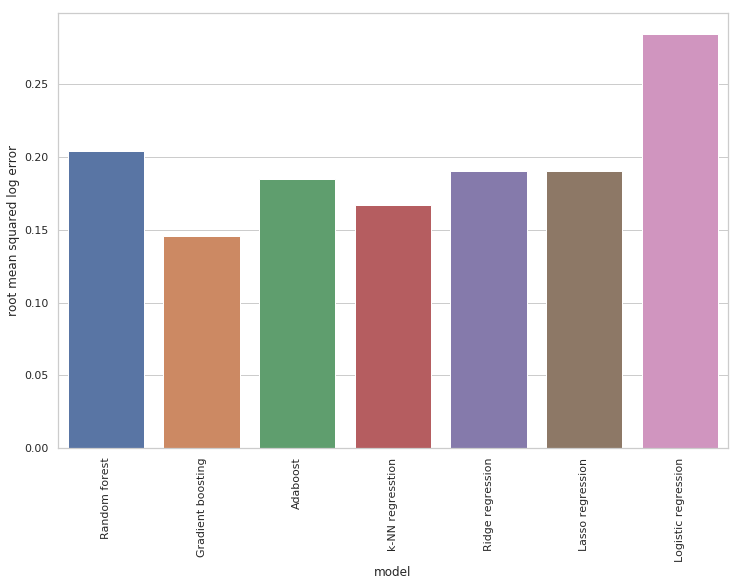

In [255]:
#bar graph of model scores
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=x_model, y=y_rmsle)
plt.xticks(rotation='vertical')
plt.xlabel('model')
plt.ylabel('root mean squared log error')
plt.show()